In [1]:

from zipfile import ZipFile
file_name = '/content/segmenation.zip'

with ZipFile(file_name, 'r') as zipr:
  zipr.extractall()
  print('Done')


Done


In [2]:
#from io import IncrementalNewlineDecoder
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split


import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout, Lambda, Conv2D, Convolution2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from unet import *


In [3]:
# setting size parametrs of images
im_width= 256
im_height = 256

## Load the image and mask paths

In [4]:
image_filenames_train= []
## crateting a list of all files containing the word mask
mask_files = glob('./lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
  image_filenames_train.append(i.replace('_mask',''))
print(image_filenames_train[:10])

['./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_3.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_47.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_36.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_19.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_20.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_15.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_43.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_27.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_31.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_41.tif']


In [5]:
mask_files[:10]

['./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_3_mask.tif',
 './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_47_mask.tif',
 './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_36_mask.tif',
 './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_19_mask.tif',
 './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_20_mask.tif',
 './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_15_mask.tif',
 './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_43_mask.tif',
 './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_27_mask.tif',
 './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_31_mask.tif',
 './lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_41_mask.tif']

In [6]:
from utils import *
plot_from_img_path(3,3, image_filenames_train)

In [7]:
tst_img=cv2.imread( mask_files[2])
np.unique(tst_img)

array([  0, 255], dtype=uint8)

In [8]:
tst_img.shape

(256, 256, 3)

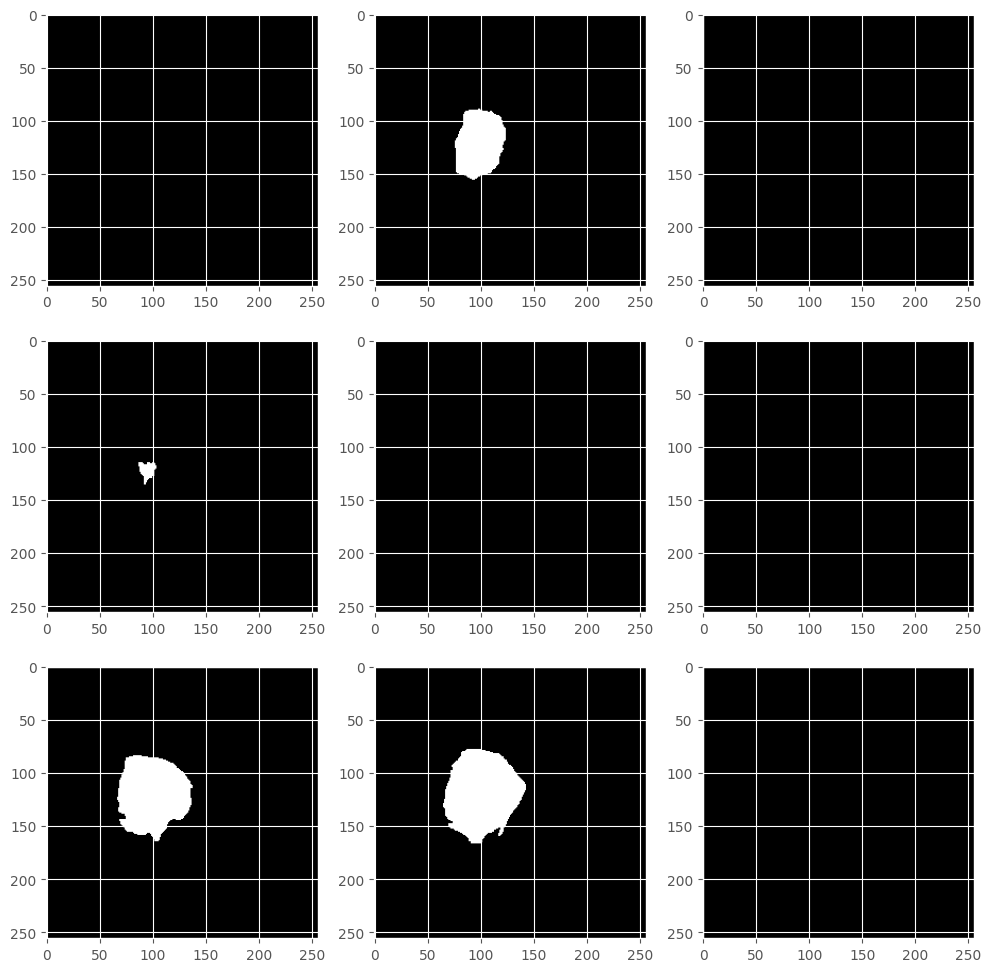

In [9]:
plot_from_img_path(3,3, mask_files)

## Create a dataframe and split data on train set, validation set and test set

In [10]:
df = pd.DataFrame({'image_filenames_train':image_filenames_train, 'mask': mask_files} )

In [11]:
df

image_filenames_train  \
0     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...   
1     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...   
2     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...   
3     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...   
4     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...   
...                                                 ...   
3924  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...   
3925  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...   
3926  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...   
3927  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...   
3928  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...   

                                                   mask  
0     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...  
1     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...  
2     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...  
3     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...  
4     ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...  
...                                                 ...  
3924  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...  
3925  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...  
3926  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...  
3927  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...  
3928  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...  

[3929 rows x 2 columns]

In [12]:
df['image_filenames_train']

0       ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...
1       ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...
2       ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...
3       ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...
4       ./lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_...
                              ...                        
3924    ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...
3925    ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...
3926    ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...
3927    ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...
3928    ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_...
Name: image_filenames_train, Length: 3929, dtype: object

In [13]:
df_train, df_test = train_test_split(df, test_size=0.1)

### further split this into train and val
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(f'training data shape {df_train.shape}')
print(f'validation data shape {df_val.shape}')
print(f'test data shape {df_test.shape}')


training data shape (2828, 2)
validation data shape (708, 2)
test data shape (393, 2)


In [14]:
df_test

image_filenames_train  \
1524  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_...   
133   ./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_...   
3776  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_...   
2181  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_...   
2304  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_...   
...                                                 ...   
242   ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_...   
416   ./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_...   
2936  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_...   
1432  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_...   
296   ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_...   

                                                   mask  
1524  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_...  
133   ./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_...  
3776  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_...  
2181  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_...  
2304  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_...  
...                                                 ...  
242   ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_...  
416   ./lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_...  
2936  ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_...  
1432  ./lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_...  
296   ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_...  

[393 rows x 2 columns]

## Data generator, data augmentation and adjust data

In [15]:
'''
After mask normalization if the value is <=0.5 then
that mask will be considered a complete black one and does not have any tumor
'''

def adjustData(img, mask):
    img= img/255
    mask= mask/255
    mask[mask<=0.5]= 0
    mask[mask>0.5] = 1
    return (img, mask)

In [16]:
def train_generator(
    data_frame,
    batch_size,
    aug_dict,
    image_color_mode = "rgb",
    mask_color_mode = "grayscale",
    image_save_prefix  = "image",
    mask_save_prefix  = "mask",
    save_to_dir = None,
    target_size = (256,256),seed = 1
):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col= 'image_filenames_train',
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col= 'mask',
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_gen = zip(image_generator, mask_generator)

    #print(train_gen)

    for (img,mask) in train_gen:
        img,mask = adjustData(img,mask)
        yield (img,mask)


In [17]:
epochs= 30
batch_size= 32
learning_rate= 1e-4

In [18]:
from unet import *

In [19]:
train_genarator_param = dict(rotation_range= 0.2,
                            width_shift_range=0.05,
                            height_shift_range= 0.05,
                            shear_range= 0.05,
                            zoom_range= 0.05,
                            horizontal_flip= True,
                            fill_mode= 'nearest'
                            )

train_gen= train_generator(df_train,batch_size,train_genarator_param,target_size=(im_width, im_height) )

val_gen = train_generator(df_val,batch_size,dict(),target_size=(im_width, im_height))

model = unet(input_size=(im_width, im_height,3))

decay_rate = learning_rate/ epochs

optimizer = Adam(lr= learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer, loss= dice_coefficient_loss, metrics=['binary_accuracy',iou,dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history= model.fit(train_gen,
                   steps_per_epoch= len(df_train)/ batch_size,
                   epochs= epochs,
                   callbacks= callbacks,
                   validation_data = val_gen,
                   validation_steps = len(df_val)/ batch_size

                   )

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/30
89/88 [==============================] - ETA: -1s - loss: -0.1625 - binary_accuracy: 0.9220 - iou: 0.0934 - dice_coefficients: 0.1635Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02195, saving model to unet.hdf5
88/88 [==============================] - 238s 2s/step - loss: -0.1625 - binary_accuracy: 0.9220 - iou: 0.0934 - dice_coefficients: 0.1635 - val_loss: -0.0220 - val_binary_accuracy: 0.9887 - val_iou: 0.0115 - val_dice_coefficients: 0.0221
Epoch 2/30
89/88 [==============================] - ETA: 0s - loss: -0.4648 - binary_accuracy: 0.9896 - iou: 0.3157 - dice_coefficients: 0.4667
Epoch 2: val_loss improved from -0.02195 to -0.02470, saving model to unet.hdf5
88/88 [==============================] - 160s 2s/step - loss: -0.4648 - binary_accuracy: 0.9896 - iou: 0.3157 - dice_coefficients: 0.4667 - val_loss: -0.0247 - val_bina

In [20]:
import pprint
pprint.pprint(history.history)

{'binary_accuracy': [0.9220043420791626,
                     0.9896009564399719,
                     0.9926692843437195,
                     0.9933072924613953,
                     0.9939852952957153,
                     0.9942101836204529,
                     0.9944976568222046,
                     0.99423748254776,
                     0.9944632649421692,
                     0.994600772857666,
                     0.9949668645858765,
                     0.994833767414093,
                     0.9949633479118347,
                     0.9953571557998657,
                     0.9955441951751709,
                     0.9955093860626221,
                     0.9954622387886047,
                     0.9958409070968628,
                     0.9957679510116577,
                     0.9957681894302368,
                     0.9958224296569824,
                     0.9962252974510193,
                     0.9963804483413696,
                     0.996216356754303,
                     

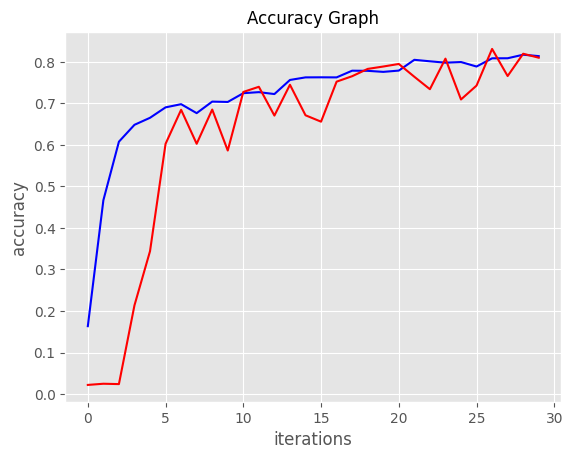

In [28]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
val_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jacard_list = history_post_training['iou']
val_jacard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
val_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(train_loss_list,'b-',)
plt.plot(val_loss_list,'r-', )

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list,'b-')
plt.plot(val_dice_coeff_list,'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy Graph', fontsize=12)

plt.show()



### Load previously trained model

In [31]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficient_loss':dice_coefficient_loss, 'iou': iou, 'dice_coefficients':dice_coefficients})

In [32]:
test_gen = train_generator(df_test,batch_size,dict(),target_size=(im_width, im_height))

In [33]:
results = model.evaluate(test_gen, steps= len(df_test)/batch_size)

print(f'Test loss {results[0]}')
print(f'Test IOU {results[1]}')
print(f'Test Dice Coefficient {results[2]}')


Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 12s 916ms/step - loss: -0.7903 - binary_accuracy: 0.9967 - iou: 0.6641 - dice_coefficients: 0.7914
Test loss -0.7903446555137634
Test IOU 0.9966757297515869
Test Dice Coefficient 0.6641073226928711


In [34]:
len(df_test.index)

393

### Plotting Predicted Masks Segemtation results from the Test Image set

1/1 [==============================] - 2s 2s/step


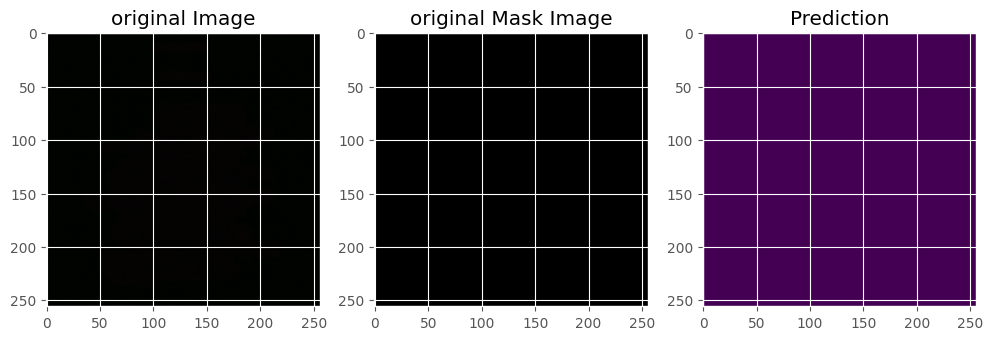

1/1 [==============================] - 0s 21ms/step


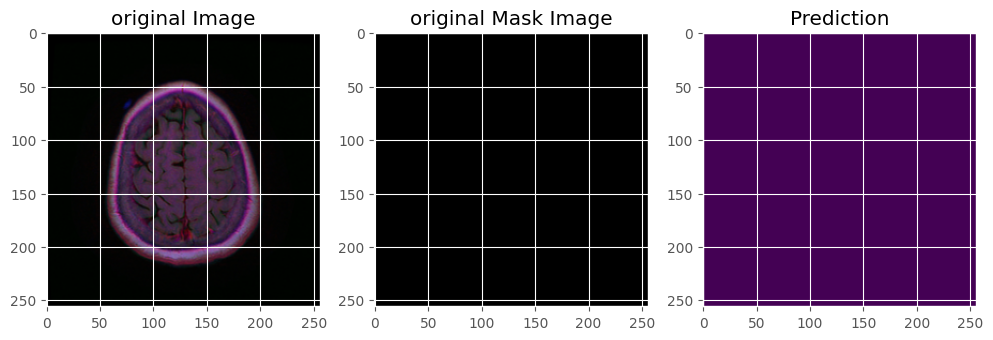

1/1 [==============================] - 0s 21ms/step


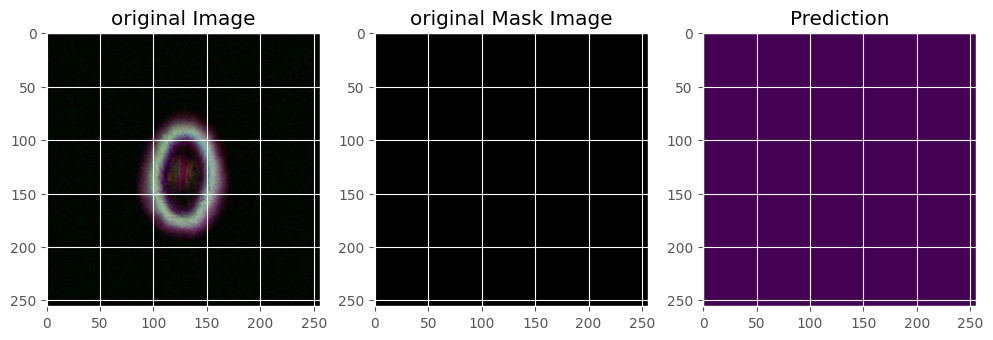

1/1 [==============================] - 0s 20ms/step


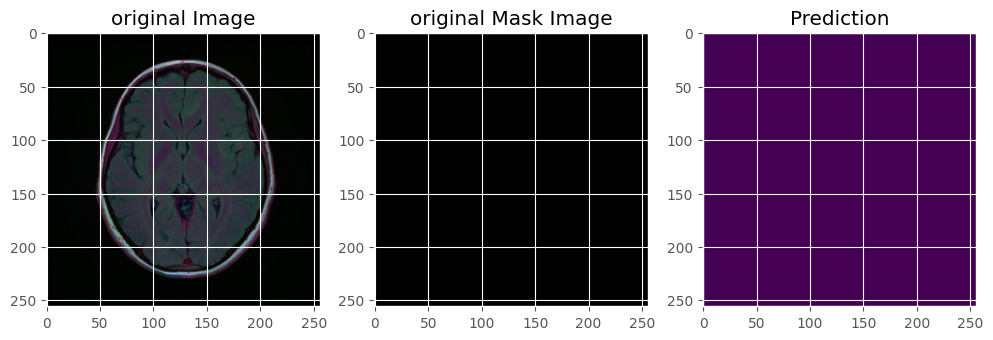

1/1 [==============================] - 0s 22ms/step


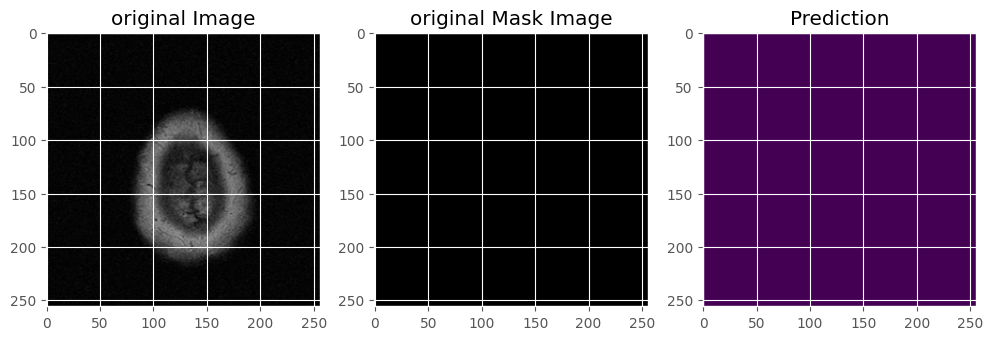

1/1 [==============================] - 0s 20ms/step


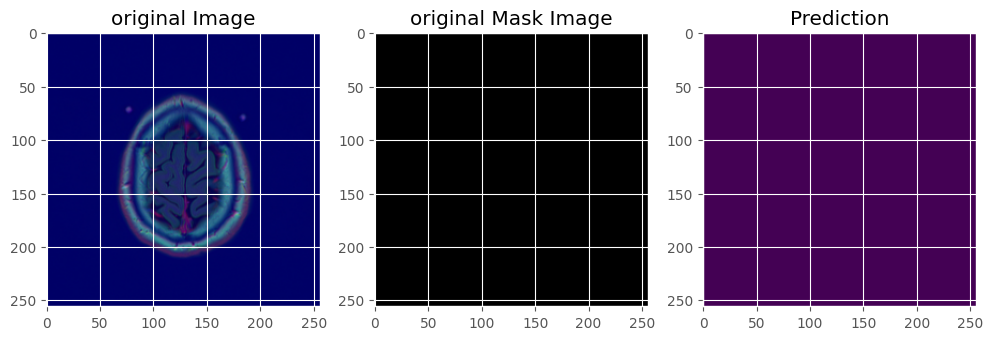

1/1 [==============================] - 0s 22ms/step


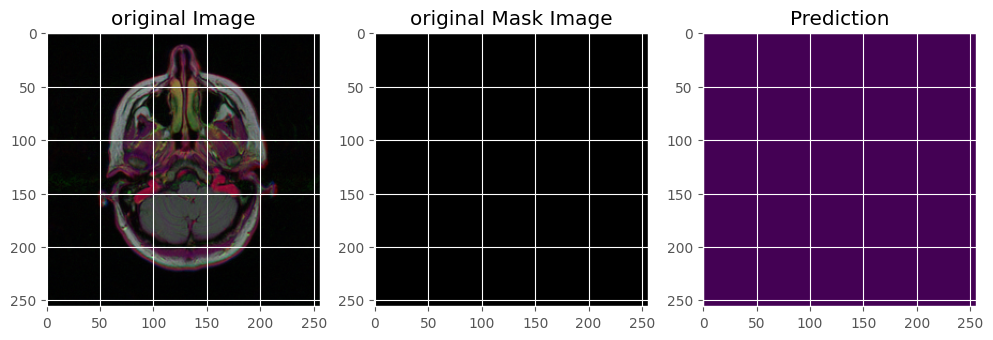

1/1 [==============================] - 0s 35ms/step


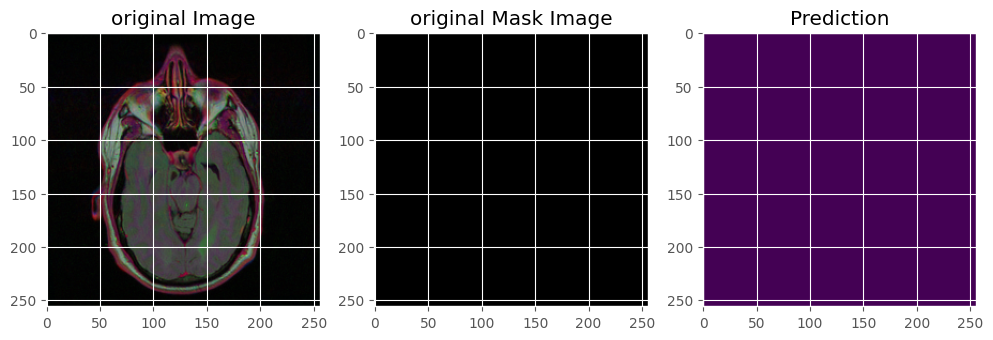

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


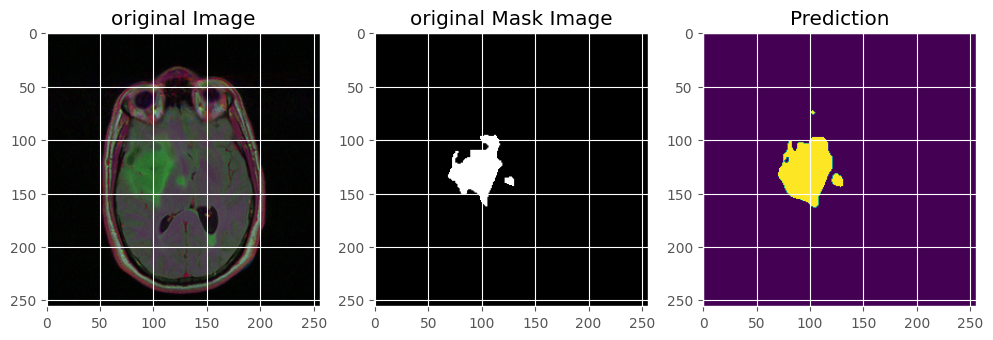

1/1 [==============================] - 0s 40ms/step


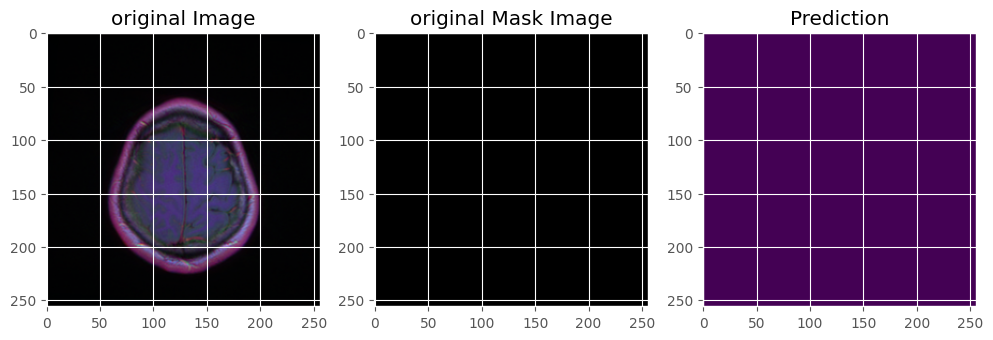

1/1 [==============================] - 0s 36ms/step


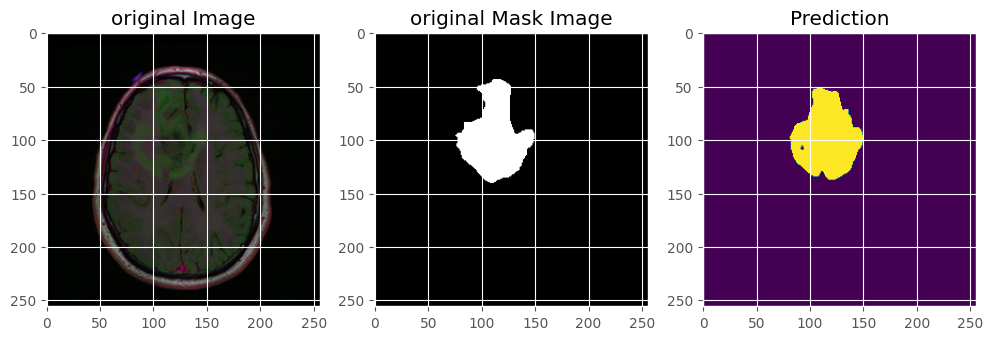

1/1 [==============================] - 0s 30ms/step


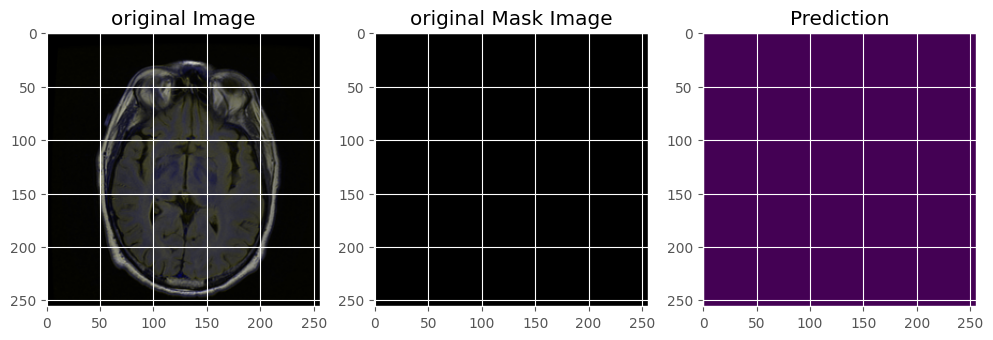

1/1 [==============================] - 0s 29ms/step


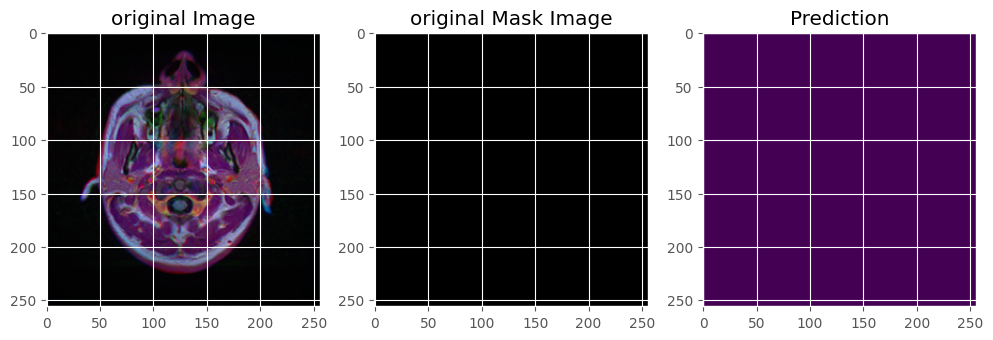

1/1 [==============================] - 0s 24ms/step


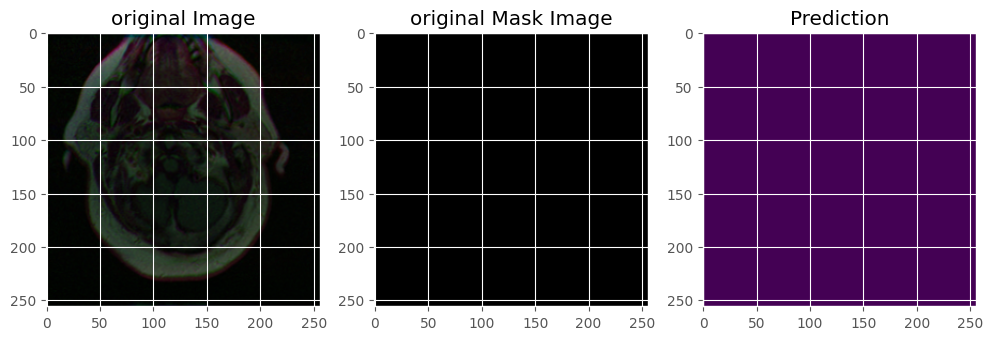

1/1 [==============================] - 0s 28ms/step


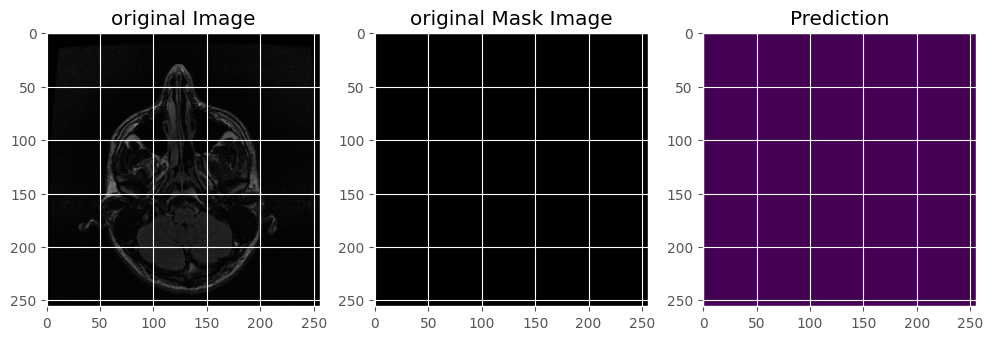

1/1 [==============================] - 0s 22ms/step


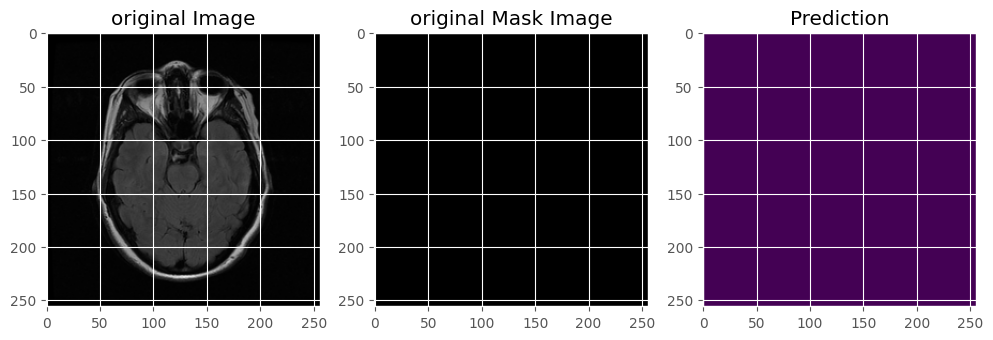

1/1 [==============================] - 0s 22ms/step


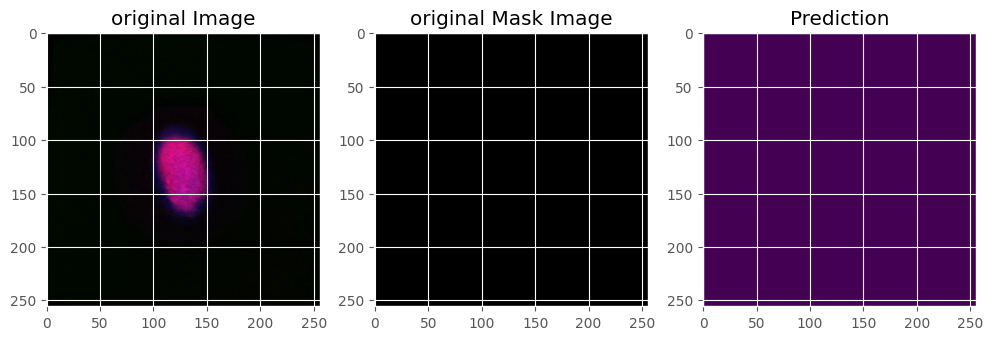

1/1 [==============================] - 0s 25ms/step


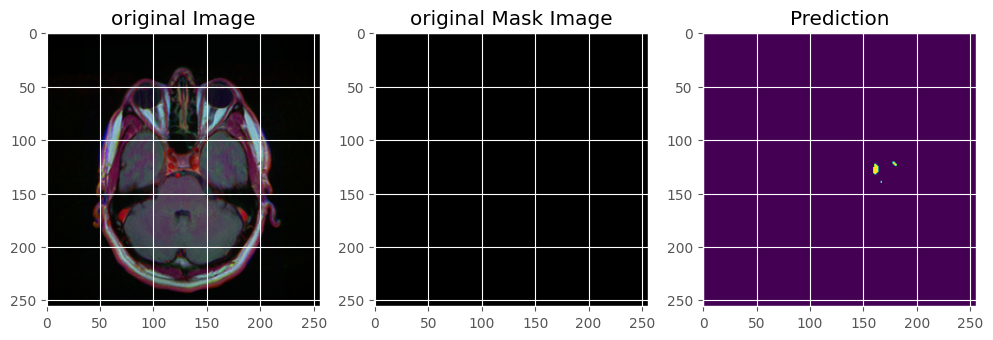

1/1 [==============================] - 0s 29ms/step


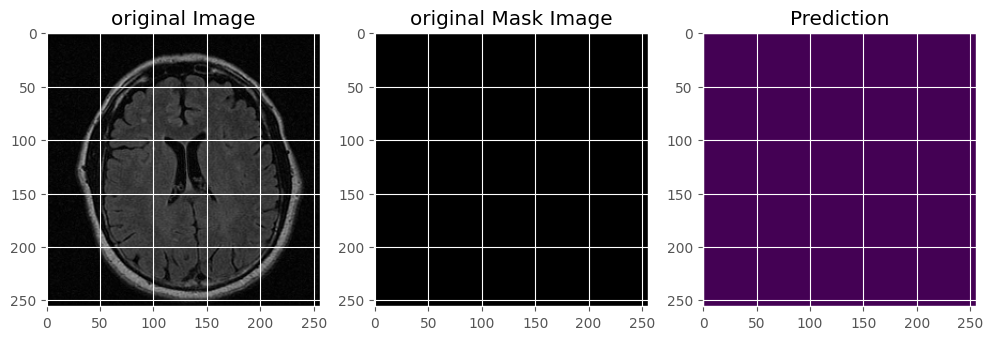

In [37]:
for i in range(20):
    index= np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_width, im_height))
    img = img/255
    img = img[np.newaxis,:,:,:]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('original Image')

    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('original Mask Image')

    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(predicted_img)>0.5)
    plt.title('Prediction')

    plt.show()

